In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from datetime import datetime
from keystroke_module import *

In [ ]:
# TO DO: kontrola bledow np. w konstruktorze klasy -?
# zalozenie minimalnej dlugosci: 100 czy 150? (bo wynika ze w ciagu 6min z 1.datasetu najmniej to 107 i 117, reszta co najmniej 150 kikniec, srednio na osobe wychodzi 600)

Patients with PD:  42
Patients without PD:  43


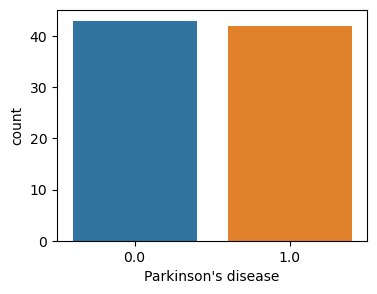

In [6]:
filename1 = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv'
filename2 = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv'
path = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/all/'

data1 = nqDataset(filename1, filename2)
data1.show_stats()

In [7]:
data1.prepare_dataset(path, feature_extract=2)
print(data1.trainset.shape)

0
1
2
Not enough samples ( 4 ) in this window - it has to be omitted
Not enough samples ( 4 ) in this window - it has to be omitted
Special case - number of keys:  372
3
Special case - number of keys:  478
4
Special case - number of keys:  417
5
Not enough samples ( 1 ) in this window - it has to be omitted
Not enough samples ( 1 ) in this window - it has to be omitted
Special case - number of keys:  345
6
Not enough samples ( 4 ) in this window - it has to be omitted
Not enough samples ( 4 ) in this window - it has to be omitted
Special case - number of keys:  174
7
8
9
10
11
12
Special case - number of keys:  345
13
Special case - number of keys:  460
14
Special case - number of keys:  301
15
16
Special case - number of keys:  439
17
Special case - number of keys:  409
18
19
Special case - number of keys:  428
20
21
22
23
24
Not enough samples ( 1 ) in this window - it has to be omitted
Not enough samples ( 4 ) in this window - it has to be omitted
Not enough samples ( 4 ) in this wi

In [8]:
data1.train_ground_truth

array([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 1.])

In [5]:
class tappyDataset:
    def __init__(self, path1, path2):

        # load data
        self.files_list1 = os.listdir(path1)
        self.files_list2 = os.listdir(path2)
        users = [el.split("_")[1].split(".")[0] for el in self.files_list1]
        df = pd.DataFrame(data=users, columns=['pID'])

        for i, el in enumerate(df['pID']):
            temp = [x for x in self.files_list2 if x.startswith(el)]
            if len(temp):
                df.loc[[i], 'files'] = pd.Series([temp], index=df.index[[i]])
                with open(path1 + self.files_list1[i], 'r') as f:
                    for line in f:
                        if 'Parkinsons' in line:
                            read_info = line.strip().split(": ")
                            df.loc[[i], 'Parkinsons'] = read_info[1]

        df.dropna(inplace=True)
        df['Parkinsons'] = df['Parkinsons'].map({'True': 1.0, 'False': 0.0})

        self.user_info = df

        # split for train and test
        self.train_df, self.test_df = train_test_split(
            self.user_info, test_size=0.3, random_state=42)

        self.train_ground_truth = self.train_df['Parkinsons'].to_numpy()
        self.test_ground_truth = self.test_df['Parkinsons'].to_numpy()
        self.trainset = None
        self.testset = None

    def show_stats(self):
        print('Patients with PD: ', len(
            self.user_info[self.user_info['Parkinsons'] == 1.0]))
        print('Patients without PD: ', len(
            self.user_info[self.user_info['Parkinsons'] == 0.0]))
        plt.figure(figsize=[4, 3])
        sns.countplot(x='Parkinsons', data=self.user_info)
        plt.xlabel('Parkinson\'s disease')

    @staticmethod
    def load_record(filename):
        df = pd.read_csv(filename, delimiter="\t", index_col=False, header=None, names=[
                         'User', 'Date', 'Timestamp', 'Hand', 'holdTime', 'Direction', 'flightTime', 'latencyTime'])

        df.drop(columns=['User'], inplace=True)
        df.drop(columns=['Direction'], inplace=True)

        df.iloc[:, -3:] = df.iloc[:, -
                                  3:].apply(lambda x: x.lstrip('0') if type(x) == str else x)
        df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),
                                        errors='coerce').unstack()
        df.iloc[:, -3:] = df.iloc[:, -3:].apply(lambda x: x/1000)

        grouped_data = df.groupby('Date').agg(list)
        grouped_data['Length'] = grouped_data['Timestamp'].apply(len)

        idx = grouped_data['Length'].idxmax()
        ex_rec1 = df[df['Date'] == idx].copy()

        try:
            ex_rec1['Hour'] = ex_rec1['Timestamp'].apply(
                lambda x: datetime.strptime(x, '%H:%M:%S.%f').hour)
        except ValueError as ve:
            # TO DO: check procedure of format in column, remove wrong values
            print('Procedure')
            # ex_rec1['if_correct_form'] = ex_rec1['Timestamp'].apply(lambda x: is_date_parsing(x))
            temp = ex_rec1['Timestamp'].apply(lambda x: is_date_parsing(x))
            ex_rec1.drop(ex_rec1[temp == False].index, inplace = True)
            ex_rec1['Hour'] = ex_rec1['Timestamp'].apply(
                lambda x: datetime.strptime(x, '%H:%M:%S.%f').hour)

        grouped_data = ex_rec1.groupby('Hour').agg(list)
        grouped_data['Length'] = grouped_data['Date'].apply(len)

        # jeśli jest odpowiednia liczba znakow
        if grouped_data['Length'].max() > 100:
            idx = grouped_data['Length'].idxmax()
            ex_rec2 = ex_rec1[ex_rec1['Hour'] == idx].copy()
            ex_rec2.drop('Hour', axis=1, inplace=True)
            ex_rec2.reset_index(inplace=True)

            ex_rec2['Timestamp'] = ex_rec2['Timestamp'].apply(
                lambda x: datetime.strptime(x, '%H:%M:%S.%f'))
            ex_rec2['timeLapse'] = count_time_from_0(ex_rec2)
        else:
            print('Not enough keystroke events!  ', grouped_data['Length'].max())
            ex_rec2 = []
            
        return ex_rec2

    def prepare_dataset(self, path, feature_extract=2):

        flag_fatal = [0,0]
        if feature_extract == 2:
            self.trainset = np.zeros([len(self.train_df), 22])

        for i, row in self.train_df.reset_index(inplace=False).iterrows():
            # .iloc[45:]
            # DO NOT iterate: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
            # use .apply() instead

            print(i)
            # take first file not all, but if not enough ...
            df_ID = self.load_record(path + row['files'][0])
            if len(df_ID) == 0:
                if len(row['files']) > 1:
                    print('Another file was found!')
                    df_ID = self.load_record(path + row['files'][1])
                    if len(df_ID) == 0:
                        print('Fatal - record not useful, with gt: ', self.train_ground_truth[i])
                        flag_fatal[0] += 1
                        flag_fatal[1] += self.train_ground_truth[i]
                        continue
                    else:
                        print('Success')
                else:
                    print('Only 1 file is available!')
                    continue

            df_ID = filter_record(df_ID, key_filter=False)

            if feature_extract == 2:
                va_HT, rate = feature_extract_method_2(
                    df_ID, dynamic_feature='holdTime', time_feature='timeLapse', assumed_length=360, window_time=20)
                if rate>=0.5: 
                    flag_fatal[0] += 1
                    flag_fatal[1] += self.train_ground_truth[i]
                # va_NFT, _ = feature_extract_method_2(
                #     df_ID, dynamic_feature='flightTime',  time_feature='timeLapse', assumed_length=360, window_time=20, normalize_option=True)
                # self.trainset[i, :] = np.concatenate([va_HT, va_NFT], axis=0)

        print('flag_fatal: ', flag_fatal)

Patients with PD:  162
Patients without PD:  55


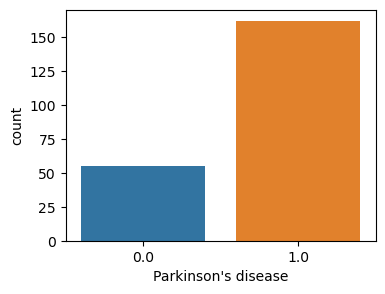

In [6]:
directory_path1 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Archived_users/'
directory_path2 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Tappy_Data/'

data2 = tappyDataset(directory_path1, directory_path2)
data2.show_stats()

In [7]:
data2.prepare_dataset(directory_path2, feature_extract=2)
print(data2.trainset.shape)

0
Flag / [% of all]:  9    0.5
Flag / [% of all]:  9    0.5
1
Not enough keystroke events!   65
Another file was found!
Not enough keystroke events!   36
Fatal - record not useful, with gt:  1.0
2


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  10    0.5555555555555556
Flag / [% of all]:  10    0.5555555555555556
3
Flag / [% of all]:  18    1.0
Flag / [% of all]:  18    1.0
4
Flag / [% of all]:  11    0.6111111111111112
Flag / [% of all]:  11    0.6111111111111112
5
Not enough keystroke events!   74
Only 1 file is available!
6
Not enough keystroke events!   9
Only 1 file is available!
7
Not enough keystroke events!   92
Another file was found!
Not enough keystroke events!   58
Fatal - record not useful, with gt:  1.0
8


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Not enough keystroke events!   92
Only 1 file is available!
9
Flag / [% of all]:  12    0.6666666666666666
Flag / [% of all]:  12    0.6666666666666666
10


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  3    0.16666666666666666
Flag / [% of all]:  3    0.16666666666666666
11
Flag / [% of all]:  18    1.0
Flag / [% of all]:  18    1.0
12
Flag / [% of all]:  9    0.5
Flag / [% of all]:  9    0.5
13


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  4    0.2222222222222222
Flag / [% of all]:  4    0.2222222222222222
14
Not enough keystroke events!   77
Another file was found!
Success
Flag / [% of all]:  15    0.8333333333333334
Flag / [% of all]:  15    0.8333333333333334
15
Not enough keystroke events!   88
Another file was found!
Success
Flag / [% of all]:  18    1.0
Flag / [% of all]:  18    1.0
16
Flag / [% of all]:  16    0.8888888888888888
Flag / [% of all]:  16    0.8888888888888888
17
Flag / [% of all]:  11    0.6111111111111112
Flag / [% of all]:  11    0.6111111111111112
18
Not enough keystroke events!   95
Only 1 file is available!
19
Flag / [% of all]:  15    0.8333333333333334
Flag / [% of all]:  15    0.8333333333333334
20
Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
21
Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
22
Flag / [% of all]:  1    0.05555555555555555
Flag / [% of all]:  1    0.05555555555555555
23


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  6    0.3333333333333333
Flag / [% of all]:  6    0.3333333333333333
43
Flag / [% of all]:  2    0.1111111111111111
Flag / [% of all]:  2    0.1111111111111111
44
Not enough keystroke events!   39
Another file was found!
Not enough keystroke events!   65
Fatal - record not useful, with gt:  1.0
45
Flag / [% of all]:  3    0.16666666666666666
Flag / [% of all]:  3    0.16666666666666666
46
Not enough keystroke events!   42
Only 1 file is available!
47


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  0    0.0
Flag / [% of all]:  0    0.0
48


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  6    0.3333333333333333
Flag / [% of all]:  6    0.3333333333333333
49
Procedure


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  13    0.7222222222222222
Flag / [% of all]:  13    0.7222222222222222
50
Flag / [% of all]:  15    0.8333333333333334
Flag / [% of all]:  15    0.8333333333333334
51
Not enough keystroke events!   62
Another file was found!


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Success
Flag / [% of all]:  12    0.6666666666666666
Flag / [% of all]:  12    0.6666666666666666
52
Not enough keystroke events!   21
Another file was found!
Not enough keystroke events!   27
Fatal - record not useful, with gt:  1.0
53
Flag / [% of all]:  5    0.2777777777777778
Flag / [% of all]:  5    0.2777777777777778
54
Flag / [% of all]:  9    0.5
Flag / [% of all]:  9    0.5
55
Flag / [% of all]:  11    0.6111111111111112
Flag / [% of all]:  11    0.6111111111111112
56
Not enough keystroke events!   92
Only 1 file is available!
57
Flag / [% of all]:  7    0.3888888888888889
Flag / [% of all]:  7    0.3888888888888889
58


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  16    0.8888888888888888
Flag / [% of all]:  16    0.8888888888888888
59


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:45: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, delimiter="\t", index_col=False, header=None, names=[
C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  11    0.6111111111111112
Flag / [% of all]:  11    0.6111111111111112
60
Flag / [% of all]:  14    0.7777777777777778
Flag / [% of all]:  14    0.7777777777777778
61
Flag / [% of all]:  2    0.1111111111111111
Flag / [% of all]:  2    0.1111111111111111
62
Flag / [% of all]:  12    0.6666666666666666
Flag / [% of all]:  12    0.6666666666666666
63


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  10    0.5555555555555556
Flag / [% of all]:  10    0.5555555555555556
64
Flag / [% of all]:  18    1.0
Flag / [% of all]:  18    1.0
65
Flag / [% of all]:  16    0.8888888888888888
Flag / [% of all]:  16    0.8888888888888888
66


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  5    0.2777777777777778
Flag / [% of all]:  5    0.2777777777777778
67
Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
68
Flag / [% of all]:  15    0.8333333333333334
Flag / [% of all]:  15    0.8333333333333334
69
Flag / [% of all]:  11    0.6111111111111112
Flag / [% of all]:  11    0.6111111111111112
70
Flag / [% of all]:  1    0.05555555555555555
Flag / [% of all]:  1    0.05555555555555555
71
Flag / [% of all]:  18    1.0
Flag / [% of all]:  18    1.0
72


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  5    0.2777777777777778
Flag / [% of all]:  5    0.2777777777777778
73
Not enough keystroke events!   53
Another file was found!
Not enough keystroke events!   20
Fatal - record not useful, with gt:  1.0
74
Flag / [% of all]:  9    0.5
Flag / [% of all]:  9    0.5
75
Flag / [% of all]:  16    0.8888888888888888
Flag / [% of all]:  16    0.8888888888888888
76


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  7    0.3888888888888889
Flag / [% of all]:  7    0.3888888888888889
77
Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
78
Flag / [% of all]:  5    0.2777777777777778
Flag / [% of all]:  5    0.2777777777777778
79
Flag / [% of all]:  15    0.8333333333333334
Flag / [% of all]:  15    0.8333333333333334
80
Flag / [% of all]:  9    0.5
Flag / [% of all]:  9    0.5
81
Flag / [% of all]:  10    0.5555555555555556
Flag / [% of all]:  10    0.5555555555555556
82
Not enough keystroke events!   49
Only 1 file is available!
83
Flag / [% of all]:  9    0.5
Flag / [% of all]:  9    0.5
84


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  16    0.8888888888888888
Flag / [% of all]:  16    0.8888888888888888
85
Not enough keystroke events!   1
Only 1 file is available!
86
Flag / [% of all]:  18    1.0


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  18    1.0
87
Flag / [% of all]:  16    0.8888888888888888
Flag / [% of all]:  16    0.8888888888888888
88
Not enough keystroke events!   90
Another file was found!
Not enough keystroke events!   6
Fatal - record not useful, with gt:  1.0
89
Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
90
Not enough keystroke events!   58
Only 1 file is available!
91


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  1    0.05555555555555555
Flag / [% of all]:  1    0.05555555555555555
92
Flag / [% of all]:  16    0.8888888888888888
Flag / [% of all]:  16    0.8888888888888888
93
Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
94
Flag / [% of all]:  7    0.3888888888888889
Flag / [% of all]:  7    0.3888888888888889
95
Flag / [% of all]:  6    0.3333333333333333
Flag / [% of all]:  6    0.3333333333333333
96
Flag / [% of all]:  4    0.2222222222222222
Flag / [% of all]:  4    0.2222222222222222
97
Not enough keystroke events!   5
Only 1 file is available!
98
Not enough keystroke events!   84
Another file was found!
Not enough keystroke events!   63
Fatal - record not useful, with gt:  0.0
99


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  3    0.16666666666666666
Flag / [% of all]:  3    0.16666666666666666
100
Not enough keystroke events!   22
Only 1 file is available!
101
Flag / [% of all]:  18    1.0
Flag / [% of all]:  18    1.0
102


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  9    0.5
Flag / [% of all]:  9    0.5
103
Flag / [% of all]:  1    0.05555555555555555
Flag / [% of all]:  1    0.05555555555555555
104
Not enough keystroke events!   28
Only 1 file is available!
105
Not enough keystroke events!   46
Another file was found!


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Success
Flag / [% of all]:  7    0.3888888888888889
Flag / [% of all]:  7    0.3888888888888889
106


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
107
Not enough keystroke events!   76
Another file was found!
Success
Flag / [% of all]:  11    0.6111111111111112
Flag / [% of all]:  11    0.6111111111111112
108
Flag / [% of all]:  7    0.3888888888888889
Flag / [% of all]:  7    0.3888888888888889
109
Flag / [% of all]:  5    0.2777777777777778
Flag / [% of all]:  5    0.2777777777777778
110
Flag / [% of all]:  11    0.6111111111111112
Flag / [% of all]:  11    0.6111111111111112
111
Flag / [% of all]:  15    0.8333333333333334
Flag / [% of all]:  15    0.8333333333333334
112
Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
113
Flag / [% of all]:  8    0.4444444444444444
Flag / [% of all]:  8    0.4444444444444444
114
Not enough keystroke events!   93
Another file was found!
Not enough keystroke events!   40
Fatal - record not useful, with gt:  1.0
115
Not enough keystroke events!   17
Another file was 

C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),
C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  7    0.3888888888888889
Flag / [% of all]:  7    0.3888888888888889
119
Not enough keystroke events!   43
Only 1 file is available!
120
Not enough keystroke events!   12
Only 1 file is available!
121
Not enough keystroke events!   33
Another file was found!
Not enough keystroke events!   34
Fatal - record not useful, with gt:  1.0
122
Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
123
Flag / [% of all]:  17    0.9444444444444444
Flag / [% of all]:  17    0.9444444444444444
124


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  1    0.05555555555555555
Flag / [% of all]:  1    0.05555555555555555
125
Flag / [% of all]:  15    0.8333333333333334
Flag / [% of all]:  15    0.8333333333333334
126
Flag / [% of all]:  14    0.7777777777777778
Flag / [% of all]:  14    0.7777777777777778
127
Procedure
Flag / [% of all]:  11    0.6111111111111112
Flag / [% of all]:  11    0.6111111111111112
128


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  11    0.6111111111111112
Flag / [% of all]:  11    0.6111111111111112
129
Flag / [% of all]:  3    0.16666666666666666
Flag / [% of all]:  3    0.16666666666666666
130
Flag / [% of all]:  2    0.1111111111111111
Flag / [% of all]:  2    0.1111111111111111
131


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  12    0.6666666666666666
Flag / [% of all]:  12    0.6666666666666666
132
Flag / [% of all]:  15    0.8333333333333334
Flag / [% of all]:  15    0.8333333333333334
133


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  16    0.8888888888888888
Flag / [% of all]:  16    0.8888888888888888
134
Flag / [% of all]:  14    0.7777777777777778
Flag / [% of all]:  14    0.7777777777777778
135
Flag / [% of all]:  14    0.7777777777777778
Flag / [% of all]:  14    0.7777777777777778
136
Flag / [% of all]:  8    0.4444444444444444
Flag / [% of all]:  8    0.4444444444444444
137
Not enough keystroke events!   72
Another file was found!
Success


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),
C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  14    0.7777777777777778
Flag / [% of all]:  14    0.7777777777777778
138
Not enough keystroke events!   66
Only 1 file is available!
139


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),
C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  0    0.0
Flag / [% of all]:  0    0.0
140
Flag / [% of all]:  6    0.3333333333333333
Flag / [% of all]:  6    0.3333333333333333
141
Not enough keystroke events!   2
Only 1 file is available!
142


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  4    0.2222222222222222
Flag / [% of all]:  4    0.2222222222222222
143
Not enough keystroke events!   6
Only 1 file is available!
144
Not enough keystroke events!   2
Only 1 file is available!
145
Not enough keystroke events!   75
Another file was found!
Not enough keystroke events!   42
Fatal - record not useful, with gt:  1.0
146
Not enough keystroke events!   53
Only 1 file is available!
147


C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),
C:\Users\Hanna\AppData\Local\Temp\ipykernel_11064\55228070.py:53: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -3:] = pd.to_numeric(df.iloc[:, -3:].stack(),


Flag / [% of all]:  4    0.2222222222222222
Flag / [% of all]:  4    0.2222222222222222
148
Flag / [% of all]:  16    0.8888888888888888
Flag / [% of all]:  16    0.8888888888888888
149
Flag / [% of all]:  1    0.05555555555555555
Flag / [% of all]:  1    0.05555555555555555
150
Flag / [% of all]:  9    0.5
Flag / [% of all]:  9    0.5
flag_fatal:  [11, 10.0]
(151, 22)


In [58]:
data2.train_ground_truth

array([1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.])

## Read data - (1. dataset)

In [81]:
# load Ground Truth
df1 = pd.read_csv('D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv')
df1.rename(columns={"updrs108": "updrs"}, inplace=True)
df1.drop('nqScore', axis=1, inplace=True)
df1.head()

,pID,gt,updrs,afTap,sTap,typingSpeed,file_1,file_2
0,11,True,14.25,NaN,162.25,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv
1,60,False,2.00,NaN,162.25,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv
2,67,True,25.25,NaN,133.75,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv
3,68,False,6.00,NaN,159.00,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv
4,70,True,26.25,NaN,113.50,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv


In [ ]:
df1.shape

(31, 8)

In [ ]:
print('Patients with PD: ', len(df1[df1['gt']==False]))
print('Patients without PD: ', len(df1[df1['gt']==True]))

Patients with PD:  13
Patients without PD:  18


In [82]:
# load Ground Truth
df2 = pd.read_csv('D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv')
df2.rename(columns={"updrs108": "updrs"}, inplace=True)
df2.drop('nqScore', axis=1, inplace=True)
df2.head()

,pID,gt,updrs,afTap,sTap,typingSpeed,file_1
0,1000,True,27,79.0,184.5,56.866667,1424946827.1000_001_014.csv
1,1001,True,16,96.5,189.0,118.000000,1427279751.1001_001_014.csv
2,1002,False,5,140.0,158.0,119.037037,1426676689.1002_001_014.csv
3,1004,True,22,83.5,191.5,74.266667,1429866367.1004_001_014.csv
4,1005,True,17,68.0,150.0,74.969697,1430134526.1005_001_014.csv


In [ ]:
print('Patients with PD: ', len(df2[df2['gt']==False]))
print('Patients without PD: ', len(df2[df2['gt']==True]))

Patients with PD:  30
Patients without PD:  24


In [83]:
df_conc = pd.concat([df1, df2], ignore_index=True)
df_conc.tail()

,pID,gt,updrs,afTap,sTap,typingSpeed,file_1,file_2
80,1063,False,0.0,110.0,170.0,109.800000,1463511198.1063_001_014.csv,NaN
81,1064,True,28.0,75.5,140.0,105.333333,1458723488.1064_001_014.csv,NaN
82,1066,True,12.0,118.0,170.5,140.250000,1460104760.1066_001_014.csv,NaN
83,1068,True,26.0,65.5,98.0,48.800000,1460559248.1068_001_014.csv,NaN
84,1070,False,2.0,126.0,154.5,54.933333,1463130212.1070_001_014.csv,NaN


Text(0.5, 0, 'Parkinson disease')

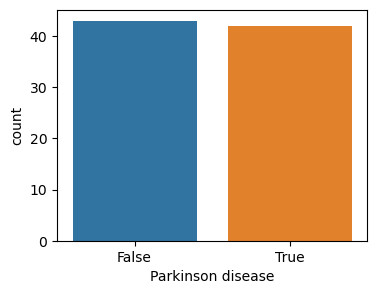

In [ ]:
plt.figure(figsize=[4,3])
sns.countplot(x = 'gt', data = df_conc)
plt.xlabel('Parkinson disease')

In [84]:
# read example file
df_ID = pd.read_csv('D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/data_MIT-CS2PD/'+ df2['file_1'][1], header = None, names=['pressedKey','holdTime', 'releaseTime', 'pressTime'])
df_ID.head()

,pressedKey,holdTime,releaseTime,pressTime
0,2,0.1135,1.4512,1.3377
1,parenright,0.1269,2.3214,2.1945
2,Shift_L,0.2064,2.3555,2.1491
3,space,0.1317,3.2163,3.0847
4,mouse_left,0.1001,6.7385,6.6384


In [89]:
len(df_ID['flightTime'])

1749

In [88]:
df_ID['flightTime'] = df_ID['pressTime'] - \
    pd.concat([pd.Series(0), df_ID['releaseTime']], ignore_index=True)
df_ID.tail()

,pressedKey,holdTime,releaseTime,pressTime,flightTime
1744,Shift_L,0.3029,771.9147,771.6118,-0.2687
1745,Return,0.0978,774.1936,774.0958,2.1811
1746,minus,0.0979,774.5318,774.4340,0.2404
1747,space,0.1241,775.0568,774.9327,0.4009
1748,Shift_L,0.6236,778.9472,778.3236,3.2668


In [92]:
df_ID['latencyTime']=df_ID['flightTime']+pd.concat([pd.Series(0),df_ID['holdTime']],ignore_index=True)
df_ID.tail()

,pressedKey,holdTime,releaseTime,pressTime,flightTime,latencyTime
1744,Shift_L,0.3029,771.9147,771.6118,-0.2687,-0.1766
1745,Return,0.0978,774.1936,774.0958,2.1811,2.4840
1746,minus,0.0979,774.5318,774.4340,0.2404,0.3382
1747,space,0.1241,775.0568,774.9327,0.4009,0.4988
1748,Shift_L,0.6236,778.9472,778.3236,3.2668,3.3909


In [ ]:
# len(df_ID[df_ID['holdTime']>1])/len(df_ID)
len(df_ID[df_ID['holdTime']>5])

33

### Filtering  (1. dataset)

In [ ]:
# basic filters
print(df_ID.shape)
df_ID_new = df_ID.drop(df_ID[df_ID['holdTime']>5].index)
print(df_ID_new.shape)
df_ID_new.drop(df_ID_new[df_ID_new['holdTime']<0].index, inplace=True)
print(df_ID_new.shape)
df_ID_new.drop(df_ID_new[df_ID_new['releaseTime']<0].index, inplace=True)
print(df_ID_new.shape)

(1749, 6)
(1716, 6)
(1716, 6)
(1716, 6)


In [ ]:
# filters for 1. dataset

pattern = 'mouse|BackSpace|Shift|Alt|Control|Num_Lock|Return|P_Enter|Caps_Lock|Left|Right|Up|Down'
pattern += '|more|less|exclamdown|\[65027\]|\[65105\]|ntilde|minus|equal|bracket|semicolon|slash|apostrophe|grave|question|right|left'

# re.compile()
# spację zostawiamy, comma i period takze
len(df_ID_new[df_ID_new['pressedKey'].str.contains(pattern, regex=True)])/1750
# jak dużo danych tracimy w wyniku filtracji? ~10%

df_ID_new = df_ID_new[~df_ID_new['pressedKey'].str.contains(pattern, regex=True)]
print(df_ID_new.shape)

(1573, 6)


In [ ]:
# import nqDataLoader as nq
# pressedKey, holdTime, pressTime, releaseTime= nq.getDataFiltHelper(fileIn)

### Feature extraction - 1. approach  (1. dataset)

In [ ]:
# https://www.nature.com/articles/srep34468

# to będzie potem w zapętleniu x razy, x - liczba blokow Bi
df_newtemp = df_ID[df_ID['releaseTime'] < 90]  # zakładana długość
Q1 = df_newtemp['holdTime'].quantile(q=0.25)
Q3 = df_newtemp['holdTime'].quantile(q=0.75)
IQR = Q3 - Q1
upper_lim = Q3 + 1.5*IQR
lower_lim = Q1 - 1.5*IQR
vout = len(df_newtemp[(df_newtemp['holdTime'] < lower_lim)
           | (df_newtemp['holdTime'] > upper_lim)])
viqr = (df_newtemp['holdTime'].quantile(q=0.5 - Q1))/(Q3 - Q1)
hist, bin_edges = np.histogram(df_newtemp['holdTime'], bins=4, density=True)
vhist1, vhist2, vhist3, vhist4 = hist * np.diff(bin_edges)
# vde - dla wszystkich i potem dodac czy inaczej?

### Feature extraction - 2. approach  (1. dataset)

7
0.11932857142857144
19
0.11850526315789472
24
0.11509166666666666
43
0.11420000000000001
44
0.1181181818181818
47
0.1245851063829787
54
0.1181314814814815
46
0.1117717391304348
41
0.10615121951219512
43
0.11436511627906977
55
0.1078509090909091
52
0.11059230769230771
55
0.11260181818181822
49
0.16230816326530612
56
0.2390196428571429
37
0.15952702702702704
36
0.2908055555555555
47
0.11350425531914891
(18, 18)


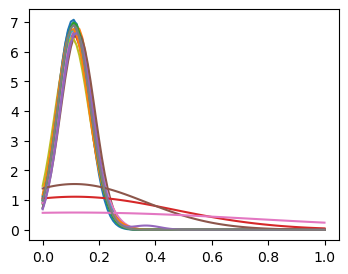

In [ ]:
# https://www.nature.com/articles/s41598-018-25999-0

# 15-seconds non-overlapping time windows
assumed_length = 360  # first condition
# window_time = 15  # time width of window
window_time = 20  # time width of window

va = feature_extract_method_2(df_ID_new , dynamic_feature='holdTime', assumed_length=assumed_length, window_time=window_time)

In [ ]:
va

array([1.36469890e-01, 5.00133506e-02, 1.39509793e-01, 2.33804120e-01,
       8.57285655e+00, 1.50883781e+01, 1.85257573e+00, 2.31663868e+00,
       2.78770593e+00, 1.54881843e+00, 4.76697714e+02])

## Read data - (2. dataset TAPPY)

In [5]:
directory_path1 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Archived_users/'
files_list1 = os.listdir(directory_path1)

users = [el.split("_")[1].split(".")[0] for el in files_list1]
df_ID2 = pd.DataFrame(data=users, columns=['pID'])

directory_path2 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Tappy_Data/'
files_list2 = os.listdir(directory_path2)

for i, el in enumerate(df_ID2['pID']):
    temp = [x for x in files_list2 if x.startswith(el)]
    if len(temp):
        df_ID2.loc[[i], 'files'] = pd.Series([temp], index=df_ID2.index[[i]])
        with open(directory_path1 + files_list1[i], 'r') as f:
            for line in f:
                if 'Parkinsons' in line:       
                    read_info = line.strip().split(": ")
                    df_ID2.loc[[i], 'Parkinsons'] = read_info[1]
                                      
df_ID2.dropna(inplace=True)
df_ID2

,pID,files,Parkinsons
0,0EA27ICBLF,"[0EA27ICBLF_1607.txt, 0EA27ICBLF_1608.txt]",True
1,0QAZFRHQHW,"[0QAZFRHQHW_1609.txt, 0QAZFRHQHW_1610.txt]",False
3,1HOEBIGASW,[1HOEBIGASW_1702.txt],False
5,1XNJCXS3EY,[1XNJCXS3EY_1608.txt],False
6,2JTCBKUP8T,"[2JTCBKUP8T_1702.txt, 2JTCBKUP8T_1703.txt]",True
...,...,...,...
222,ZT9ASWFCFS,[ZT9ASWFCFS_1606.txt],True
223,ZWBPPNQCUX,"[ZWBPPNQCUX_1608.txt, ZWBPPNQCUX_1612.txt]",True
224,ZWHGXDUDLG,[ZWHGXDUDLG_1703.txt],True
225,ZY9CCHSPF2,"[ZY9CCHSPF2_1607.txt, ZY9CCHSPF2_1608.txt, ZY9...",True


Text(0.5, 0, 'Parkinson disease')

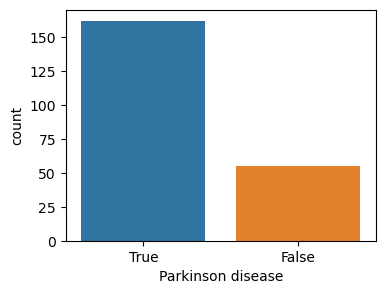

In [30]:
plt.figure(figsize=[4,3])
sns.countplot(x = 'Parkinsons', data = df_ID2)
plt.xlabel('Parkinson disease')

In [14]:
df_ID2.loc[[0], 'files'][0][0]

'0EA27ICBLF_1607.txt'

In [36]:
data2 = pd.read_csv(directory_path2 + df_ID2['files'].iloc[1][0], delimiter="\t", index_col=False, header=None, names=[
                    'User', 'Date', 'Timestamp', 'Hand', 'holdTime', 'Direction', 'flightTime', 'latencyTime'])

data2.drop(columns=['User'], inplace=True)
data2.drop(columns=['Direction'], inplace=True)

data2.iloc[:, -3:] = data2.iloc[:, -
                                3:].apply(lambda x: x.lstrip('0') if type(x) == str else x)
data2.iloc[:, -3:] = pd.to_numeric(data2.iloc[:, -3:].stack(),
                                   errors='coerce').unstack()
data2.iloc[:, -3:] = data2.iloc[:, -3:].apply(lambda x: x/1000)
data2.head()

,Date,Timestamp,Hand,holdTime,flightTime,latencyTime
0,160916,19:20:43.891,L,0.0781,0.3125,0.2578
1,160916,19:20:44.344,L,0.0781,0.4531,0.3750
2,160916,19:20:44.742,L,0.0625,0.4141,0.3359
3,160916,19:20:45.516,L,0.0938,0.7422,0.6797
4,160916,19:20:46.047,R,0.1016,0.5234,0.4297


In [37]:
grouped_data = data2.groupby('Date').agg(list)
grouped_data['Length'] = grouped_data['Timestamp'].apply(len) 
grouped_data

,Timestamp,Hand,holdTime,flightTime,latencyTime,Length
Date,,,,,,
160916,"[19:20:43.891, 19:20:44.344, 19:20:44.742, 19:...","[L, L, L, L, R, R]","[0.07809999999999999, 0.07809999999999999, 0.0...","[0.3125, 0.4531, 0.4141, 0.7422000000000001, 0...","[0.25780000000000003, 0.375, 0.3359, 0.6797000...",6
160918,"[10:35:01.508, 10:35:01.930, 10:35:02.164, 10:...","[L, R, R, L, R, R, R, R, L, L, L, R, R, L, R, ...","[0.10940000000000001, 0.21480000000000002, 0.0...","[0.2891, 0.31639999999999996, 0.38280000000000...","[0.1758, 0.207, 0.168, 0.3906, 0.2813, 0.07809...",80
160919,"[18:39:21.977, 18:39:22.477, 18:39:22.922, 21:...","[L, L, L, R, L, L, R, L, R, L, R, L, L, R]","[0.07809999999999999, 0.0703, 0.07809999999999...","[0.4219, 0.5078, 0.4375, 0.4063, 0.30469999999...","[0.3438, 0.42969999999999997, 0.36719999999999...",14
160921,"[16:34:25.703, 16:34:27.164, 16:45:29.914, 16:...","[L, L, L, L, R, L, L, L]","[0.0938, 0.10940000000000001, 0.125, 0.1406, 0...","[0.4531, 0.5117, 0.3359, 0.3555, 0.49610000000...","[0.3438, 0.418, 0.2266, 0.21480000000000002, 0...",8
160922,"[08:40:36.512, 08:40:37.027, 08:40:37.402, 08:...","[L, L, L, R, L, L, L, R, R, R, L, L, L, R, R, ...","[0.07809999999999999, 0.07809999999999999, 0.0...","[0.3594, 0.5156000000000001, 0.3906, 0.2031, 0...","[0.2813, 0.4375, 0.3125, 0.125, 0.2344, 0.1211...",559
160923,"[15:54:36.141, 15:54:36.688, 15:54:36.938, 15:...","[L, L, L, L, R, R, L, R, L, S, R, R, L, R, L, ...","[0.0938, 0.0938, 0.0938, 0.10940000000000001, ...","[0.1875, 0.5468999999999999, 0.25, 0.7813, 0.5...","[0.0938, 0.4531, 0.15630000000000002, 0.6875, ...",51
160925,"[09:04:27.662, 09:04:29.318]","[L, L]","[0.1211, 0.1465]","[0.4043, 0.6347999999999999]","[0.3477, 0.5078]",2
160926,"[14:19:25.395, 14:19:26.031, 14:19:26.680, 14:...","[L, R, L, R, L, L, L, R, R, L, L, R, R]","[0.1055, 0.15230000000000002, 0.082, 0.1367, 0...","[0.5468999999999999, 0.5898, 0.7188, 0.7109, 0...","[0.4141, 0.4844, 0.5664, 0.6289, 0.1875, 0.574...",13
160927,"[13:47:29.781, 13:47:31.344, 19:24:13.188, 19:...","[L, L, L, R, R, R, L, R, R, R, L, R, R, L, R, ...","[0.0938, 0.15630000000000002, 0.1641, 0.1172, ...","[0.44139999999999996, 0.44139999999999996, 0.2...","[0.3281, 0.3281, 0.10940000000000001, 0.2734, ...",30


In [38]:
idx=grouped_data['Length'].idxmax() # jeśli jest odpowiednia liczba znakow
new_rec=data2[data2['Date']==idx].copy()
print(new_rec)

       Date     Timestamp Hand  holdTime  flightTime  latencyTime
108  160922  08:40:36.512    L    0.0781      0.3594       0.2813
109  160922  08:40:37.027    L    0.0781      0.5156       0.4375
110  160922  08:40:37.402    L    0.0625      0.3906       0.3125
111  160922  08:40:57.775    R    0.1055      0.2031       0.1250
112  160922  14:15:30.012    L    0.0938      0.3828       0.2344
..      ...           ...  ...       ...         ...          ...
662  160922  22:36:15.094    R    0.1094      0.2188       0.0625
663  160922  22:36:16.766    R    0.0781      0.1875       0.1250
664  160922  22:36:19.953    L    0.1406      0.6094       0.5156
665  160922  22:36:20.312    R    0.0938      0.4063       0.2656
666  160922  22:36:20.820    R    0.0781      0.5234       0.4297

[559 rows x 6 columns]


In [39]:
new_rec['Hour'] = new_rec['Timestamp'].apply(lambda x: datetime.strptime(x,'%H:%M:%S.%f').hour)
grouped_data = new_rec.groupby('Hour').agg(list)
grouped_data['Length'] = grouped_data['Date'].apply(len) 
grouped_data

,Date,Timestamp,Hand,holdTime,flightTime,latencyTime,Length
Hour,,,,,,,
8,"[160922, 160922, 160922, 160922]","[08:40:36.512, 08:40:37.027, 08:40:37.402, 08:...","[L, L, L, R]","[0.07809999999999999, 0.07809999999999999, 0.0...","[0.3594, 0.5156000000000001, 0.3906, 0.2031]","[0.2813, 0.4375, 0.3125, 0.125]",4
14,"[160922, 160922, 160922, 160922, 160922, 16092...","[14:15:30.012, 14:15:30.230, 14:15:31.391, 14:...","[L, L, L, R, R, R, L, L, L, R, R, L, S, L, R, ...","[0.0938, 0.09770000000000001, 0.1016, 0.1016, ...","[0.38280000000000003, 0.21480000000000002, 0.2...","[0.2344, 0.1211, 0.10940000000000001, 0.4219, ...",547
19,"[160922, 160922]","[19:50:28.297, 19:50:29.625]","[L, L]","[0.0938, 0.125]","[0.4688, 0.4531]","[0.3281, 0.3438]",2
22,"[160922, 160922, 160922, 160922, 160922, 160922]","[22:36:14.922, 22:36:15.094, 22:36:16.766, 22:...","[L, R, R, L, R, R]","[0.15630000000000002, 0.10940000000000001, 0.0...","[0.2031, 0.21880000000000002, 0.1875, 0.609399...","[0.0625, 0.0625, 0.125, 0.5156000000000001, 0....",6


In [40]:
idx = grouped_data['Length'].idxmax()
new_rec2 = new_rec[new_rec['Hour'] == idx].copy()
new_rec2.drop('Hour', axis=1, inplace=True)
new_rec2.reset_index(inplace=True)

new_rec2['Timestamp'] = new_rec2['Timestamp'].apply(
    lambda x: datetime.strptime(x, '%H:%M:%S.%f'))
new_rec2['timeLapse'] = count_time_from_0(new_rec2)
new_rec2.tail()

,index,Date,Timestamp,Hand,holdTime,flightTime,latencyTime,timeLapse
542,654,160922,1900-01-01 14:27:19.980,R,0.0781,0.6094,0.4688,709.968
543,655,160922,1900-01-01 14:27:20.246,L,0.0938,0.2500,0.1719,710.234
544,656,160922,1900-01-01 14:27:20.652,L,0.0938,0.4063,0.3125,710.640
545,657,160922,1900-01-01 14:27:26.520,L,0.1250,0.2500,0.1406,716.508
546,658,160922,1900-01-01 14:27:26.926,R,0.1094,0.4219,0.2969,716.914


In [41]:
# 15-seconds non-overlapping time windows
assumed_length = 360  # first condition
# window_time = 15  # time width of window
window_time = 20  # time width of window

va = feature_extract_method_2(new_rec2, dynamic_feature='holdTime', time_feature='timeLapse',
                              assumed_length=assumed_length, window_time=window_time)

Not enough samples ( 0 ) in this window - it has to be omitted
Not enough samples ( 0 ) in this window - it has to be omitted


In [45]:
va

array([8.75727016e-02, 3.27005404e-02, 1.99486850e-02, 8.94289640e-03,
       1.17791025e+00, 1.77851598e+00, 6.29716979e-01, 7.02424983e-01,
       3.31683079e+00, 1.69230319e+00, 5.67178066e+02])

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder() #-> L or S or R
y = labelencoder_y.fit_transform(y)